# **Layers**

This notebook is a guide to understand how `neurophox` defines a unitary mesh architecture. Our module allows for machine learning with orthogonal and unitary matrices and can be deployed in larger deep learning networks (e.g., [tunable unitary RNNs](http://proceedings.mlr.press/v70/jing17a)). However, it is also useful to understand how these layers work at the core level as well as how to perform diagnostics and visualizations of mesh layers.

Unitary meshes are composed of $L$ vertical layer operations, and the $\ell$th vertical layer consists of a permutation matrix and a tunable coupling matrix parametrized by phase shift weights $\theta_{n\ell}, \phi_{n\ell}$, where $n$ represents the waveguide index. The product of successively applied vertical layers results in a unitary matrix. This is the core contribution of `neurophox`. Any unitary mesh network can be expressed this way and therefore a range of different architectures can be efficiently simulated and used for machine learning or photonics experiments.

**Important:** It is important to note that the full rectangular mesh (`RM`) and triangular mesh (`TM`) layers are too large for many deep learning applications. Alternatives to these meshes can be made using a permuting rectangular mesh (`PRM`) or using a small value (less than 10 or so) for `num_layers` in the `RM` or `TM` layers. These will generally run faster on a GPU, so that is recommended as well.

## Pairwise unitary

The fundamental unit of the mesh network is the pairwise unitary operator (in photonics, known as a Mach-Zehnder interferometer (MZI) component), which comprises of four stages:
1. Hadamard transformation, $H$:
$$
\begin{align}
H &= \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}
\end{align}
$$
or Beamsplitter transformation $B$:
$$
\begin{align}
B &= \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & i\\
i & 1
\end{bmatrix}
\end{align}
$$
2. Differential phase shift, $D(\theta)$:
$$
\begin{align}
R(\theta) &= \begin{bmatrix}
e^{i \theta / 2} & 0\\
0 & e^{-i \theta / 2}
\end{bmatrix}
\end{align}
$$
or upper phase shift, $L(\theta)$:
$$
\begin{align}
L(\theta) &= \begin{bmatrix}
e^{i \theta} & 0\\
0 & 1
\end{bmatrix}
\end{align}
$$
3. Hadamard transformation, $H$ or Beamsplitter transformation $B$
4. Upper phase shift, $L(\phi)$.

Thus, the total unitary transformation at layer $\ell$ and input index pair $n, n+1$ within a mesh is (in the *Hadamard* convention):

$$
\begin{align}
U(\theta_{n,\ell}, \phi_{n,\ell}) &= H D(\theta_{n,\ell}) H L(\phi_{n,\ell})\\
&= \begin{bmatrix}
e^{i \phi_{n,\ell}}\cos \frac{\theta_{n,\ell}}{2} & i\sin \frac{\theta_{n,\ell}}{2}\\
ie^{i \phi_{n,\ell}}\sin \frac{\theta_{n,\ell}}{2} & \cos \frac{\theta_{n,\ell}}{2}
\end{bmatrix}
\end{align}
$$

The total unitary transformation at layer $\ell$ and input pair $n, n+1$ within a mesh is (in the *beamsplitter* convention, default in `neurophox`):

$$
\begin{align}
U(\theta_{n, \ell}, \phi_{n, \ell}) &= B D(\theta_{n, \ell}) B L(\phi_{n, \ell})\\
&= i\begin{bmatrix}
e^{i \phi_{n, \ell}}\sin \frac{\theta_{n, \ell}}{2} & \cos \frac{\theta_{n, \ell}}{2}\\
e^{i \phi_{n, \ell}}\cos \frac{\theta_{n, \ell}}{2} & -\sin \frac{\theta_{n, \ell}}{2}
\end{bmatrix}
\end{align}
$$

Note that we typically use $D(\theta)$ as it removes an extra global phase term; this makes the top and bottom rows act like a Bloch sphere, hence we call this a "Bloch basis." In the photonics literature, $L(\theta)$ seems to be more common, leaving a global phase term for $\theta$ out front; we call this the "single-mode basis." Both bases behave similarly and generally do not affect optimization performance. In `neurophox`, we default to the Bloch basis to simplify the expression for $U$, but the user can specify whether they want to use the single mode basis as an argument.

## Vertical MZI Layers

In our [paper](https://arxiv.org/pdf/1808.00458.pdf), specifically Figure 1, we mention the concept of "vertical" MZI layers, layers that contain Givens rotations (pairwise unitary operations) that can be applied simultaneously. 

For a *general feedforward mesh* in `neurophox`, we follow a different definition for a mesh with $N$ inputs and outputs:

$$
\begin{align}
U_{N, \ell}(\boldsymbol{\theta}_\ell, \boldsymbol{\phi}_\ell) &= \prod_{m \leq \lfloor N / 2 \rfloor} U_{2m}^{[N]}(\theta_{2m, \ell}, \phi_{2m, \ell}) P_{N, \ell} \\
U_N(\boldsymbol{\theta}, \boldsymbol{\phi},\boldsymbol{\gamma}) &= P_{N, L + 1} \prod_{\ell = 1}^L U_{N, \ell}(\boldsymbol{\theta}_\ell, \boldsymbol{\phi}_\ell) \cdot D_N(\boldsymbol{\gamma}),
\end{align}
$$

where $U_{2m}^{[N]}$ is a pairwise (Givens) unitary operator acting between indices $2m, 2m + 1$, $U_{N, \ell}$ is the unitary operator for the $\ell$th vertical layer (parametrized by phase vectors $\boldsymbol{\theta}_\ell, \boldsymbol{\phi}_\ell$), $U_N$ is the final unitary operator represented by the entire mesh.

## The `MeshModel` framework

The mesh model class `neurophox.meshmodel.MeshModel` defines the model for any feedforward mesh defined as in the above equation. The permutations $P_\ell$ are defined by `perm_idx` in `MeshModel`. In `neurophox`, not all of $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ need to be degrees of freedom because in many photonic architectures (e.g. rectangular and triangular grid meshes), some need to be set to bar state. For this reason, we provide an additional parameter in `MeshModel` called `num_mzis` or $M \leq \lfloor N / 2 \rfloor$ that limits the number of MZIs in each layer of the above equation. For all $m > M$, we set $\theta_{2m, \ell} = \phi_{2m, \ell} = 0$ in Hadamard convention or $\theta_{2m, \ell} = \phi_{2m, \ell} = \pi$ in Beamsplitter convention, which gives a bar state with no differential phase.

In [1]:
# core (tf, numpy, scipy, matplotlib, pbar) imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from tqdm import tqdm_notebook as pbar
# Comment this out if you do not have latex (or associated requirements) installed
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Charter']})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

import warnings
warnings.filterwarnings('ignore')

# neurophox imports
from neurophox.numpy import *

## Rectangular mesh

Let's begin by initializing a rectangular mesh for $N = 8$. A model initialized to implement a random unitary matrix on a standard rectangular mesh of $L = N$ layers can be generated by simply using the following command:

In [2]:
N = 32
np_layer = RMNumpy(N)

## Plotting options

For plotting, `neurophox` has a convenient complex matrix visualization tool, available in both tensorflow and numpy layers.

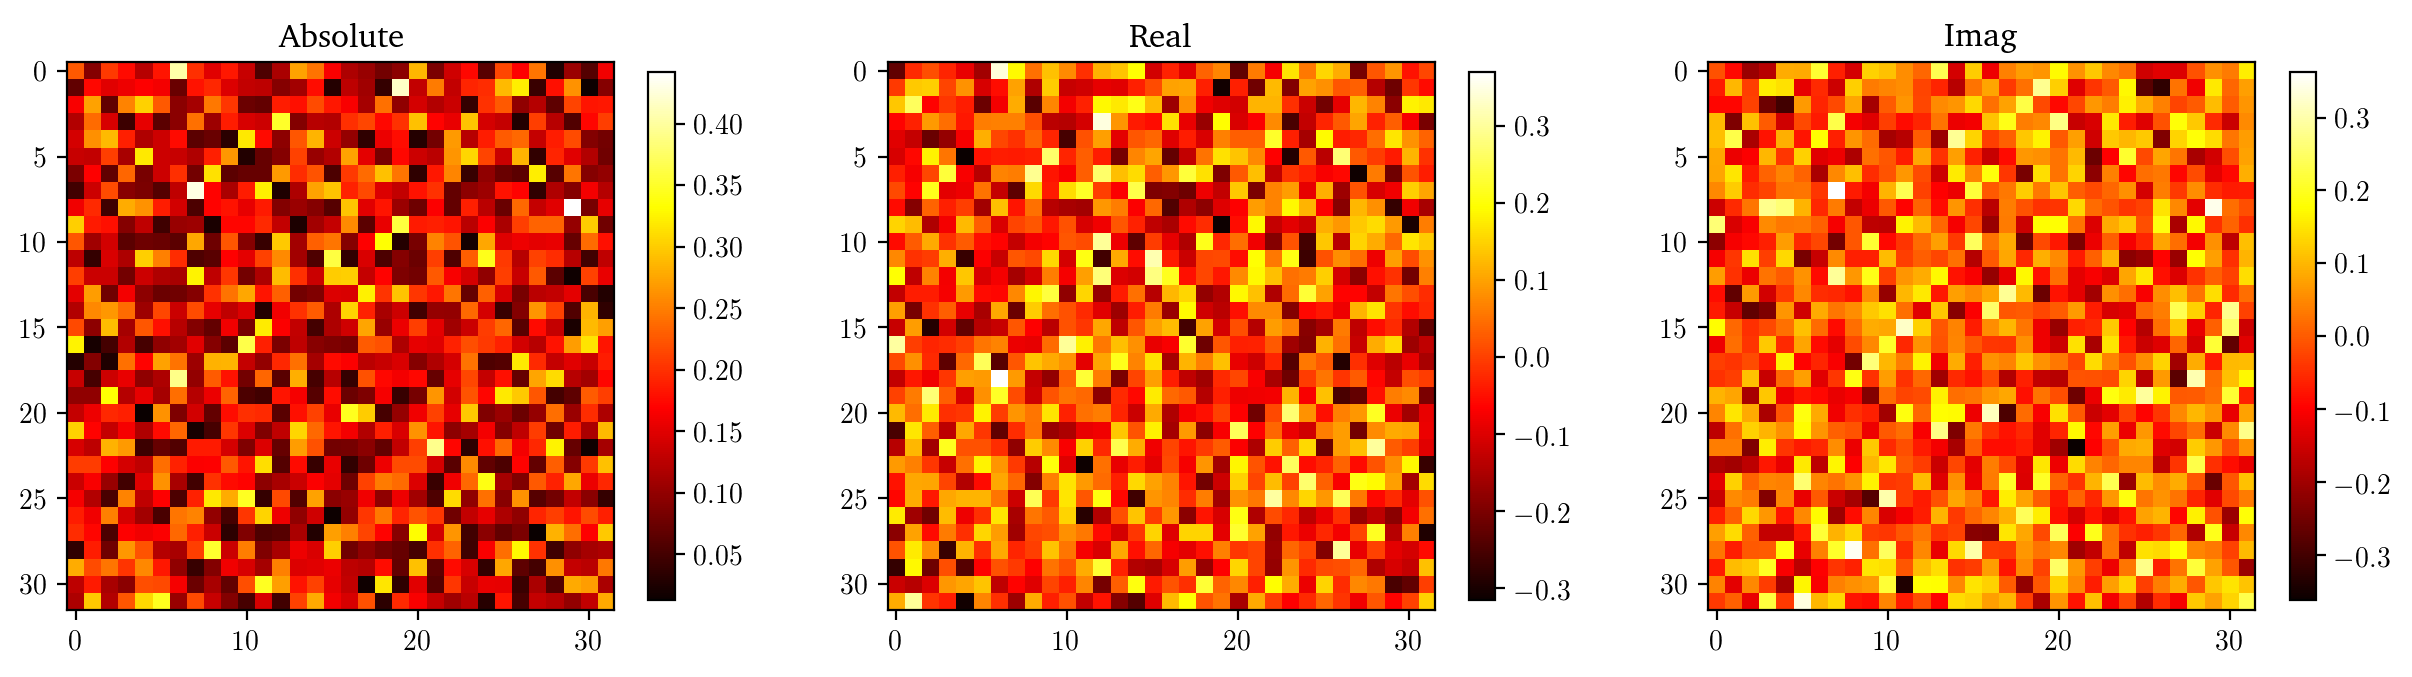

In [3]:
np_layer.plot(plt)

It is also possible to use the same utility above to visualize all of the vertical layer operators $U^{(\ell)}_{N}$. We will demonstrate this just for the first layer, but this is generally useful for diagnostics in case a new mesh layer is implemented.

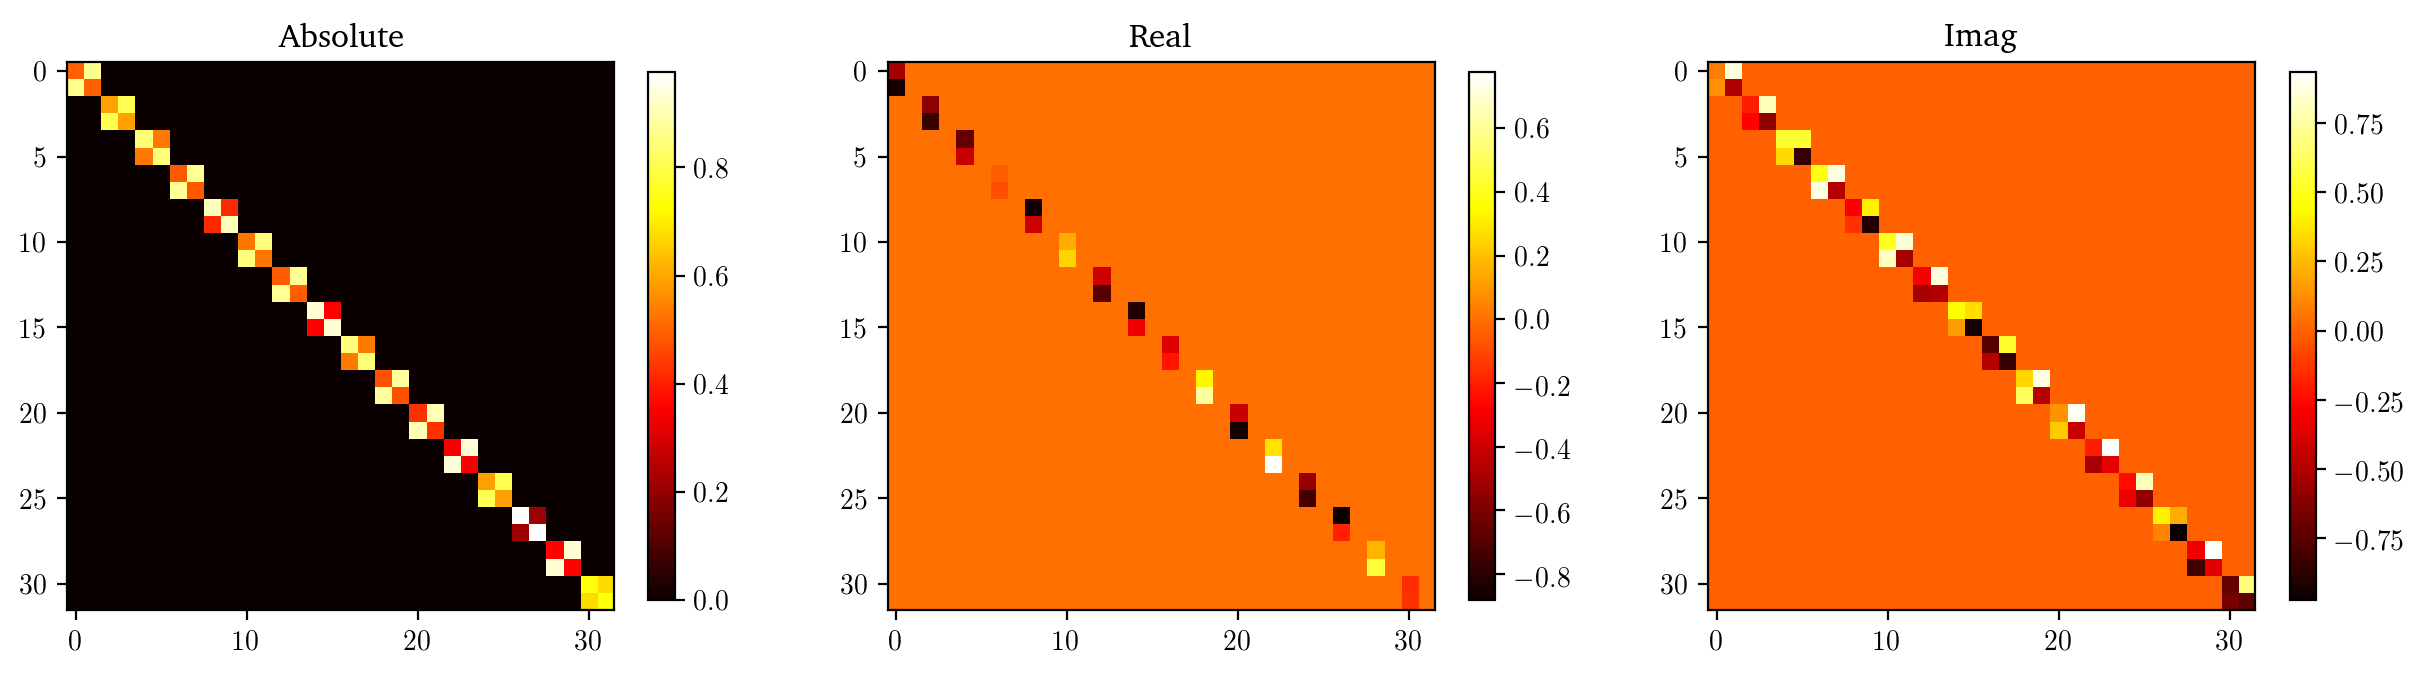

In [4]:
np_layer.mesh_layers[0].plot(plt)

## Propagation visualization

For photonics simulations, it is useful to see the propagation of light in the mesh. By propagation of light, we mean how a light shined through a single input port (equivalent to a Euclidean standard basis vector input) spreads in the mesh network. This may also be of some use for machine learning applications.

In [Figure 2 of our paper](https://arxiv.org/abs/1808.00458), we demonstrated that the initialization has a strong effect on how light propagates in the network. We demonstrate this by comparing the light propagation magnitudes after injecting into input 31 (zero-indexed) of an $N = 64$ mesh for a Haar-initialized mesh versus uniform-random initialized $\theta_{n\ell}$.

Text(0.5,1,'Propagation for uniform random $\\theta_{n\\ell}$')

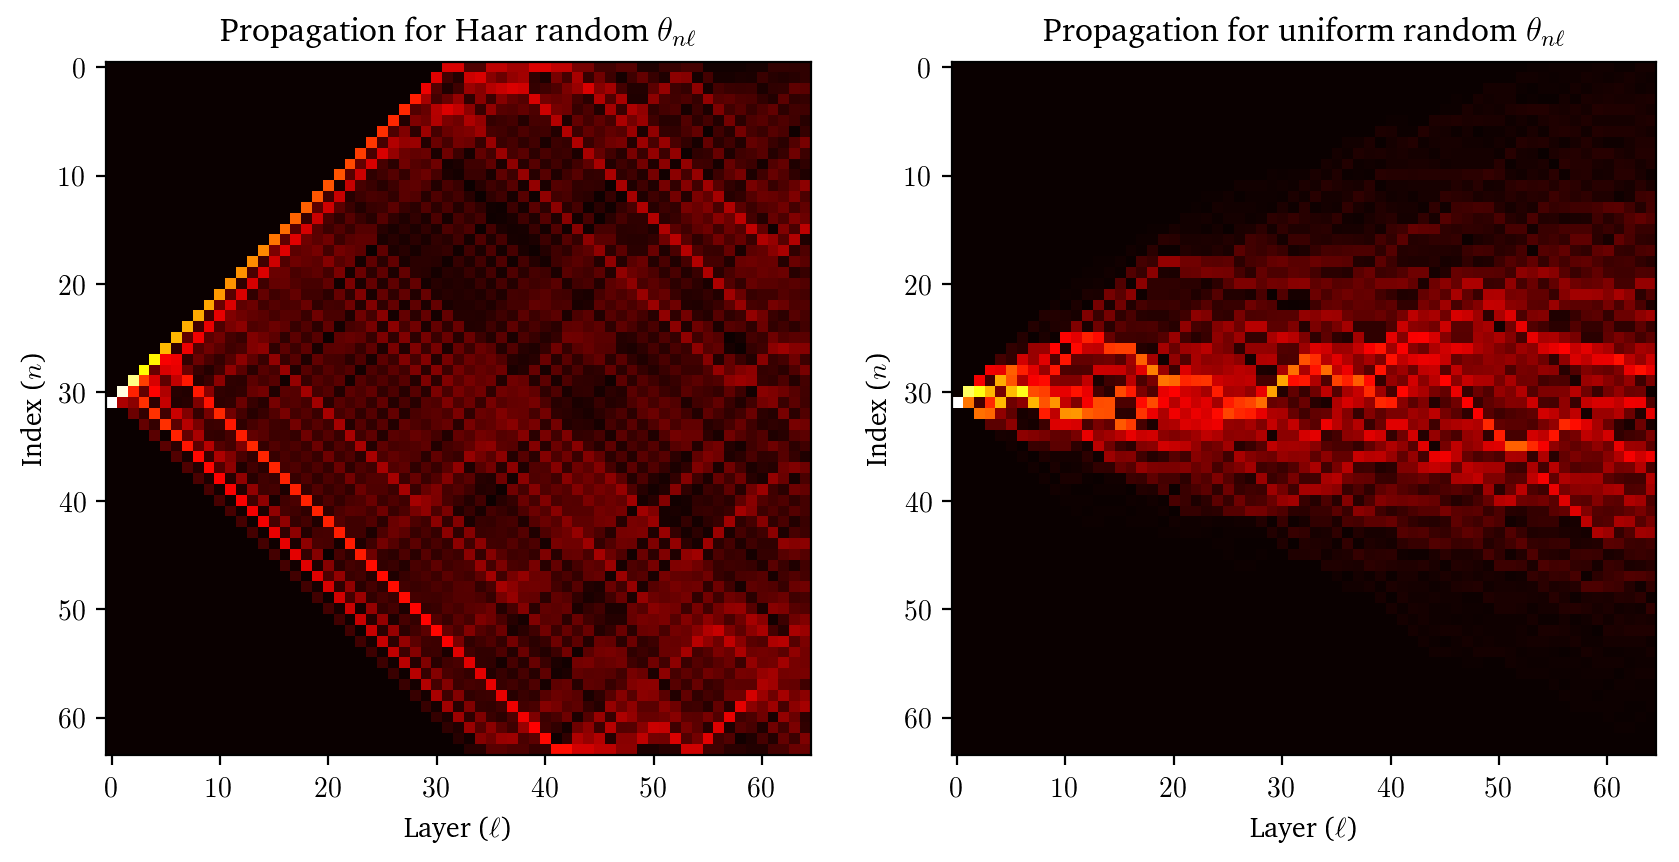

In [5]:
haar_random_layer = RMNumpy(64)  # note: theta_init_name="haar_rect"
uniform_random_layer = RMNumpy(64, theta_init_name="random_theta")

plt.figure(dpi=200, figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.abs(haar_random_layer.propagate(np.eye(64)[31]).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title('Propagation for Haar random $\\theta_{n\ell}$')
plt.subplot(122)
plt.imshow(np.abs(uniform_random_layer.propagate(np.eye(64)[31]).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title('Propagation for uniform random $\\theta_{n\ell}$')

It is particularly helpful to think about what the values of $\theta_{n\ell}$ are that produce propagation patterns like the ones shown above. To show these patterns, we have some special utilities that find the "absolute $\theta_{n\ell}$" for each of the above matrices (see [Appendix F](https://arxiv.org/abs/1808.00458)). Notice that most of the absolute $\theta_{n\ell}$ are close to zero (here, we assume Beamsplitter convention, though in Hadamard convention we might have $\theta_{n\ell}$ close to $\pi$ instead).

Text(0.5,0,'Layer ($\\ell$)')

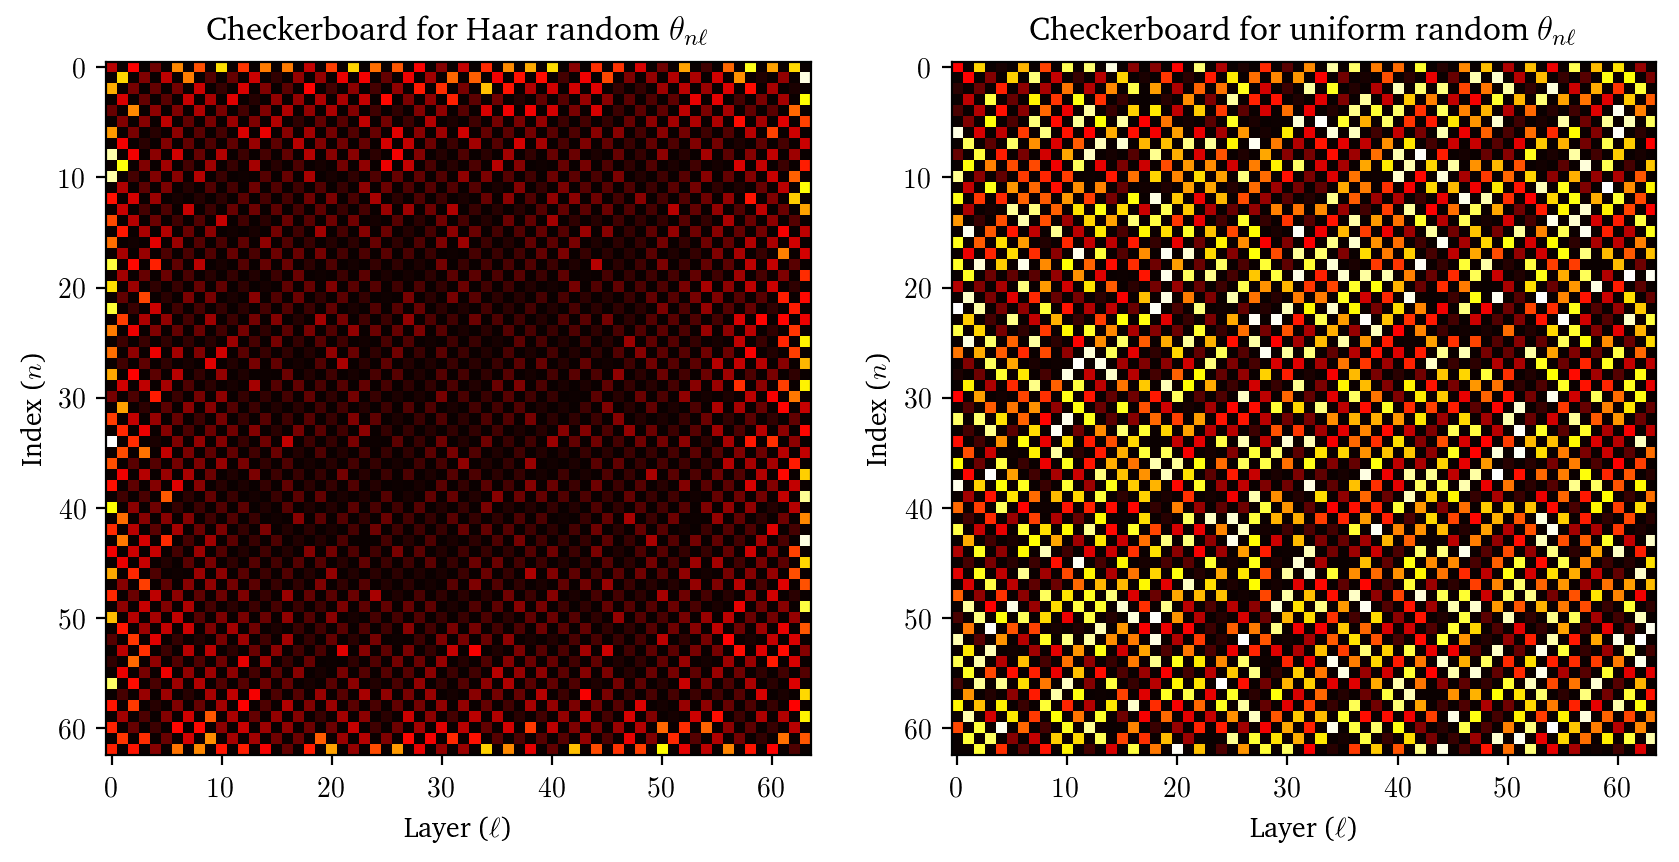

In [6]:
from neurophox.helpers import to_absolute_theta

plt.figure(dpi=200, figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.abs(to_absolute_theta(haar_random_layer.phases.theta.checkerboard_arrangement[:-2])), cmap='hot')
plt.title('Checkerboard for Haar random $\\theta_{n\ell}$')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.subplot(122)
plt.imshow(np.abs(to_absolute_theta(uniform_random_layer.phases.theta.checkerboard_arrangement[:-2])), cmap='hot')
plt.title('Checkerboard for uniform random $\\theta_{n\ell}$')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")

## Triangular mesh

Let's perform the same analysis as above, but now for the triangular mesh.

Text(0.5,0,'Layer ($\\ell$)')

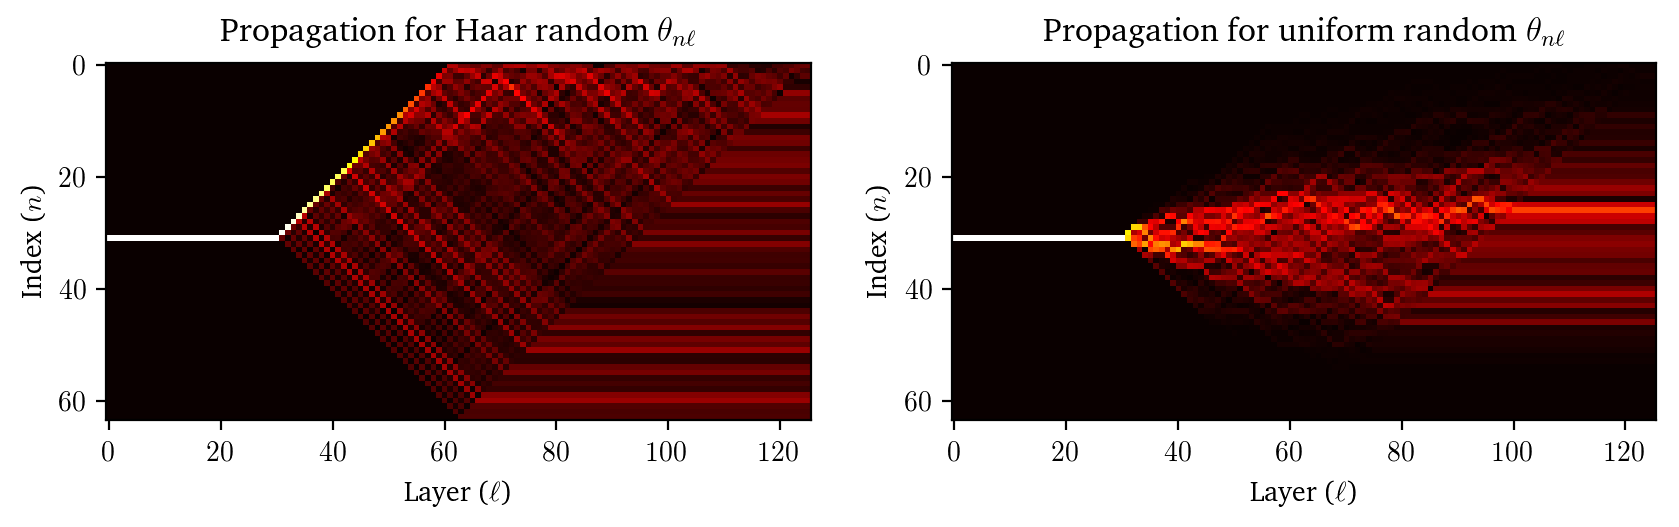

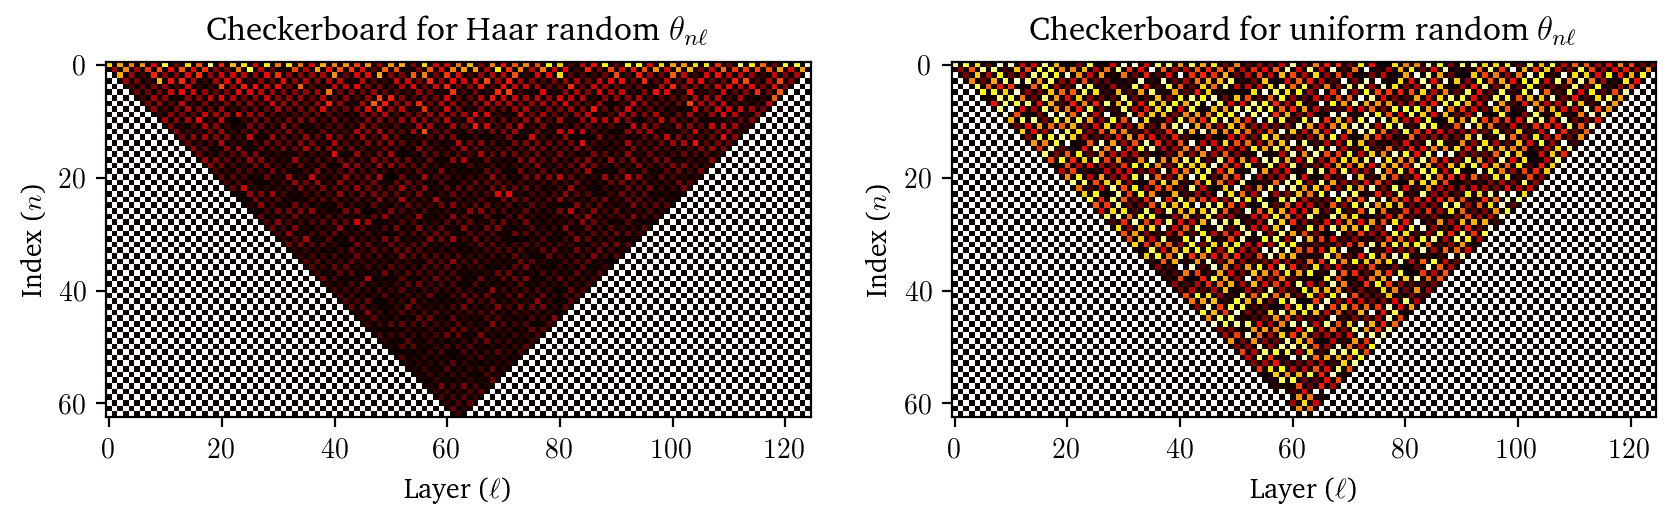

In [7]:
haar_random_layer = TMNumpy(64)  # note: theta_init_name="haar_rect"
uniform_random_layer = TMNumpy(64, theta_init_name="random_theta")

plt.figure(dpi=200, figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.abs(haar_random_layer.propagate(np.eye(64)[31]).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title('Propagation for Haar random $\\theta_{n\ell}$')
plt.subplot(122)
plt.imshow(np.abs(uniform_random_layer.propagate(np.eye(64)[31]).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title('Propagation for uniform random $\\theta_{n\ell}$')

plt.figure(dpi=200, figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.abs(to_absolute_theta(haar_random_layer.phases.theta.checkerboard_arrangement[:-2])), cmap='hot')
plt.title('Checkerboard for Haar random $\\theta_{n\ell}$')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.subplot(122)
plt.imshow(np.abs(to_absolute_theta(uniform_random_layer.phases.theta.checkerboard_arrangement[:-2])), cmap='hot')
plt.title('Checkerboard for uniform random $\\theta_{n\ell}$')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")

It is important to note that this `propagate` functionality, while useful for grid-like, locally-interacting mesh architectures such as triangular and rectangular architectures, becomes less understandable when nonlocalities are introduced, especially if each vertical layer has such nonlocalities.